# Sampling genomes for phylogenetic inference

## Summary

Select ~10k genomes out of all 86,200 reference genomes, such that they represent the largest possible biodiversity, as measured by _k_-mer signature, plus multiple other criteria concerning genome quality and marker gene count, etc.

## Preparation

### Dependencies

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from skbio.stats.distance import DistanceMatrix

In [3]:
%matplotlib inline

In [4]:
sns.set()

### Input files

Genome metadata

In [5]:
meta_fp = 'metadata.ext.tsv.xz'

In [6]:
df = pd.read_csv(meta_fp, sep='\t', index_col=0, low_memory=False)
df.shape[0]

86200

Genome distance matrix (calculated using MinHash)

In [7]:
dm_fp = 'minhash.dm.bz2'

In [8]:
%time dm = DistanceMatrix.read(dm_fp)

CPU times: user 56min 59s, sys: 4min 43s, total: 1h 1min 43s
Wall time: 1h 4min 32s


### Helpers

Core algorithm: **prototype selection**

In [9]:
def prototype_selection_destructive_maxdist(dm, num_prototypes, seedset=None):
    """Prototype selection function (minified)."""
    numRemain = len(dm.ids)
    currDists = dm.data.sum(axis=1)
    maxVal = currDists.max()
    if seedset is not None:
        for e in seedset:
            currDists[dm.index(e)] = maxVal * 2
    minElmIdx = currDists.argmin()
    currDists[minElmIdx], numRemain = np.infty, numRemain - 1
    while (numRemain > num_prototypes):
        currDists -= dm.data[minElmIdx]
        minElmIdx = currDists.argmin()
        currDists[minElmIdx], numRemain = np.infty, numRemain - 1
    return [dm.ids[idx]
            for idx, dist in enumerate(currDists)
            if dist != np.infty]

In [10]:
def distance_sum(elements, dm):
    """Calculate sum of distances among chosen genomes."""
    return np.tril(dm.filter(elements).data).sum()

Generate a histogram with an upper fence.

In [11]:
def hist_w_max(data, step, xmax):
    """Plot histogram with values > certain threshold combined in one bin."""
    bins = np.arange(0, xmax + step * 2, step)
    plt.xticks(step * np.arange(len(bins)), [str(x) for x in plt.hist(np.clip(data, bins[0],
        bins[-1]), bins=bins)[1]][:-1]+ ['Inf']);

Generate a count plot

In [12]:
def count_plot(data, percent=False, **kwargs):
    """Plot bars representing categorical counts."""
    ax = sns.countplot(data, **kwargs)
    total = float(len(data))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 3,
                '{:1.2f}'.format(height / total) if percent else str(int(height)),
                ha='center')
    ax.set_xlabel('')
    return ax

Generate a multi-panel figure to show the statistics of currently selected genomes

In [13]:
def examine_set(genomes):
    """Plot statistics of chosen genomes."""
    print('%d' % len(genomes))
    gs = mpl.gridspec.GridSpec(1, 5, width_ratios=[1, 1, 1, 1, 2])
    cols = ['markers', 'completeness', 'contamination', 'score_fna']
    ymaxes = [400, 100, 600, 1.0]
    dfc = df[df.index.isin(genomes)]
    for i, col in enumerate(cols):
        ax = plt.subplot(gs[i])
        ax.plot(dfc[col].sort_values().tolist(), color='C%d' % i)
        ax.set_title(col)
        ax.set_ylim([0, ymaxes[i]])
    m_taxa = df[df.index.isin(genomes)][ranks].apply(pd.Series.nunique)
    p_taxa = m_taxa / n_taxa * 100
    ax = plt.subplot(gs[4])
    sns.barplot(x=p_taxa.index, y=p_taxa, ax=ax)
    for i, p in enumerate(ax.patches):
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 3, m_taxa[ranks[i]], ha='center')
    ax.set_ylim([0, 110])
    ax.set_xlabel('');
    ax.set_xticklabels(['p', 'c', 'o', 'f', 'g', 's', 't'])
    ax.set_title('% included')
    plt.tight_layout();

## Analysis

### Genome metadata

Plot distributions of some metadata fields

In [14]:
mpl.rcParams['figure.figsize'] = (8, 2.5)

/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


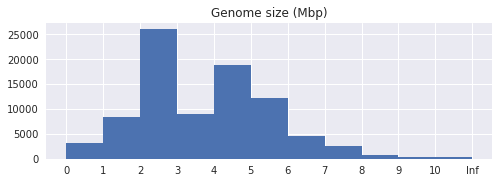

In [15]:
hist_w_max(df['total_length'] / 1000000, 1, 10)
plt.title('Genome size (Mbp)');

/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


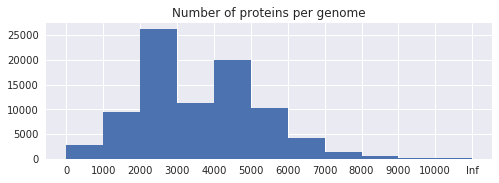

In [16]:
hist_w_max(df['proteins'], 1000, 10000)
plt.title('Number of proteins per genome');

/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


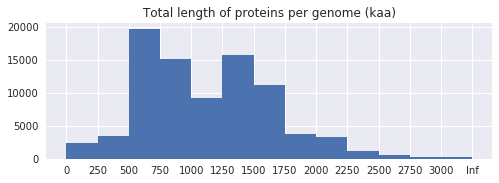

In [17]:
hist_w_max(df['protein_length'] / 1000, 250, 3000)
plt.title('Total length of proteins per genome (kaa)');

/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


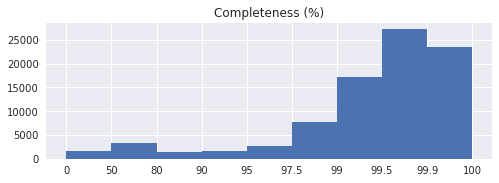

In [18]:
bins = [0, 50, 80, 90, 95, 97.5, 99, 99.5, 99.9, 100]
plt.bar(range(len(bins) - 1), np.histogram(df['completeness'], bins=bins)[0], width=1,
        align='edge')
plt.xticks(np.arange(len(bins)), [str(x) for x in bins])
plt.title('Completeness (%)');

/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


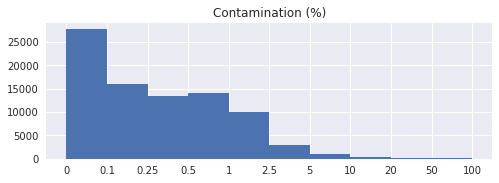

In [19]:
bins = [0, 0.1, 0.25, 0.5, 1, 2.5, 5, 10, 20, 50, 100]
plt.bar(range(len(bins) - 1), np.histogram(df['contamination'], bins=bins)[0], width=1,
        align='edge')
plt.xticks(np.arange(len(bins)), [str(x) for x in bins])
plt.title('Contamination (%)');

/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


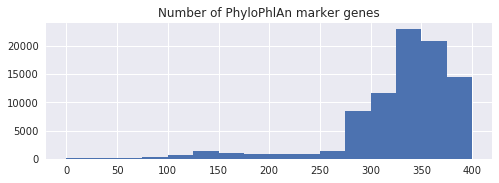

In [20]:
bins = np.arange(0, 425, 25)
plt.hist(df['markers'], bins=bins)
plt.title('Number of PhyloPhlAn marker genes');

/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


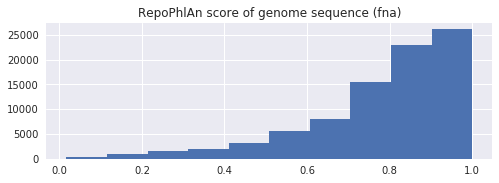

In [21]:
plt.hist(df['score_fna'])
plt.title('RepoPhlAn score of genome sequence (fna)');

/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


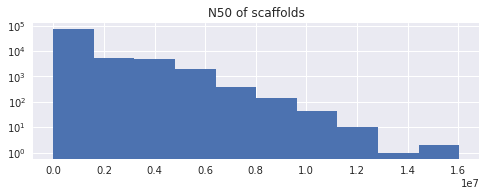

In [22]:
plt.hist(df['n50'], log=True)
plt.title('N50 of scaffolds');

/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


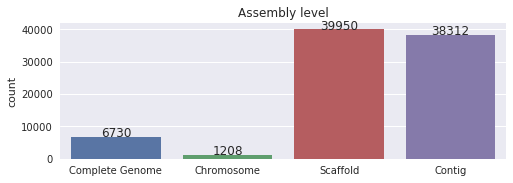

In [23]:
order=['Complete Genome', 'Chromosome', 'Scaffold', 'Contig']
count_plot(df['assembly_level'], order=order).set_title('Assembly level');

/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


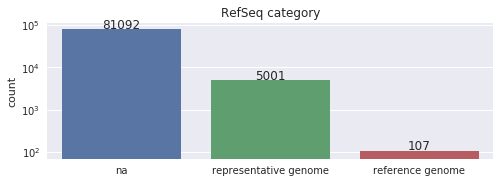

In [24]:
count_plot(df['refseq_category'], log=True).set_title('RefSeq category');

/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


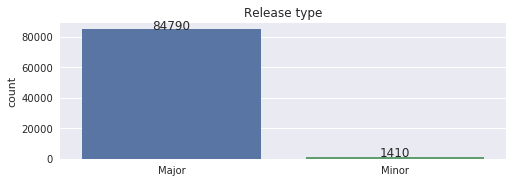

In [25]:
count_plot(df['release_type']).set_title('Release type');

In [26]:
ranks = ['phylum', 'class', 'order', 'family', 'genus', 'species']
df[ranks].describe()

,phylum,class,order,family,genus,species
count,85672,81714,80829,80456,80413,86200
unique,153,89,199,429,2117,20779
top,Proteobacteria,Bacilli,Enterobacterales,Enterobacteriaceae,Streptococcus,Staphylococcus aureus
freq,37109,25524,13496,11949,10454,7447


/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


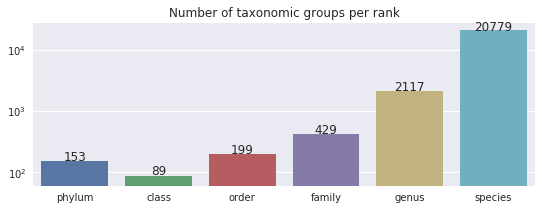

In [27]:
mpl.rcParams['figure.figsize'] = (9, 3)
n_taxa = df[ranks].apply(pd.Series.nunique)
ax = sns.barplot(x=n_taxa.index, y=n_taxa, log=True)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, str(int(height)), ha='center')
ax.set_xlabel('')
ax.set_title('Number of taxonomic groups per rank');

/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


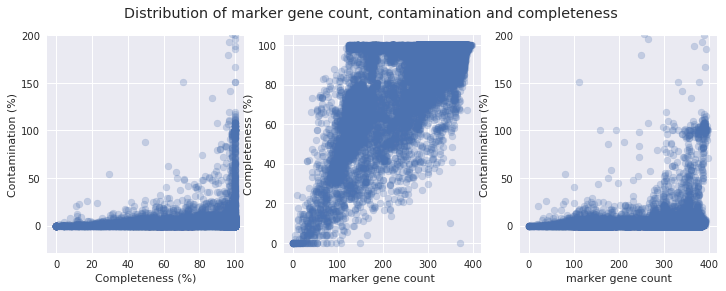

In [28]:
mpl.rcParams['figure.figsize'] = (12, 4)
f, axarr = plt.subplots(1, 3)
axarr[0].scatter(x='completeness', y='contamination', alpha=0.25, data=df)
axarr[0].set_ylim(ymax=200)
axarr[0].set_xlabel('Completeness (%)')
axarr[0].set_ylabel('Contamination (%)');
axarr[1].scatter(x='markers', y='completeness', alpha=0.25, data=df)
axarr[1].set_xlabel('marker gene count')
axarr[1].set_ylabel('Completeness (%)');
axarr[2].scatter(x='markers', y='contamination', alpha=0.25, data=df)
axarr[2].set_ylim(ymax=200)
axarr[2].set_xlabel('marker gene count')
axarr[2].set_ylabel('Contamination (%)')
plt.suptitle('Distribution of marker gene count, contamination and completeness');

Make a one-figure summary

86200


/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


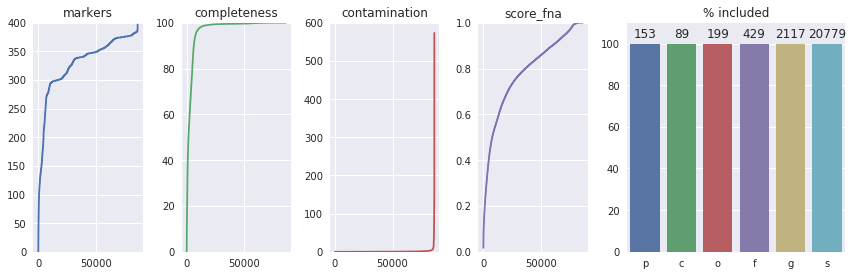

In [29]:
examine_set(df.index)

### Criteria for sampling

In [30]:
mpl.rcParams['figure.figsize'] = (12, 2.5)

Quality filtering

85498


/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


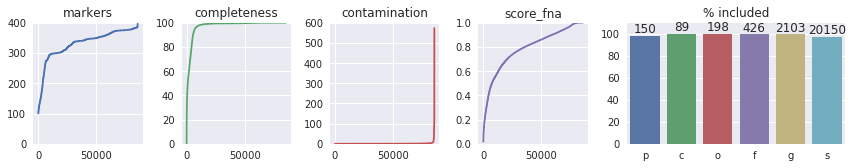

In [31]:
qualified = set(df.query('markers >= 100').index.tolist())
examine_set(qualified)

85308


/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


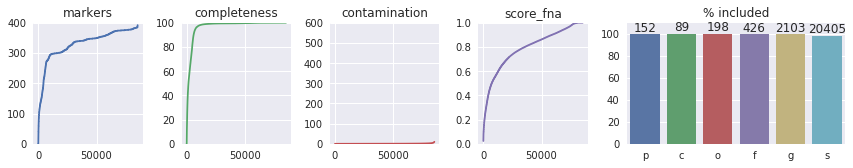

In [32]:
qualified = set(df.query('contamination <= 10').index.tolist())
examine_set(qualified)

81291


/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


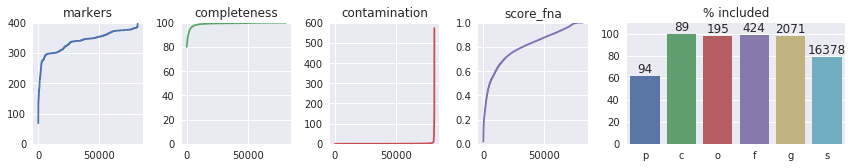

In [33]:
qualified = set(df.query('completeness >= 80').index.tolist())
examine_set(qualified)

NCBI reference and representative genomes

5108


/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


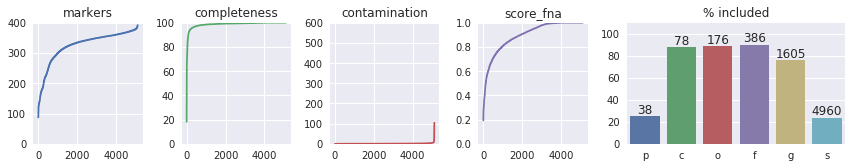

In [34]:
refp = set(df[df['refseq_category'] != 'na'].index.tolist())
examine_set(refp)

Only representatives of taxonomic groups

In [35]:
singles = {}
reports = []
for rank in ('phylum', 'class', 'order', 'family', 'genus', 'species'):
    single_taxa = [i for i, val in df[rank].value_counts().iteritems() if val == 1]
    singles[rank] = set(df[df[rank].isin(single_taxa)].index.tolist())
    reports.append('%s: %d' % (rank, len(singles[rank])))
print('Taxonomic groups with only one representative: %s' % ', '.join(reports))

Taxonomic groups with only one representative: phylum: 11, class: 8, order: 29, family: 80, genus: 834, species: 18227


11


/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


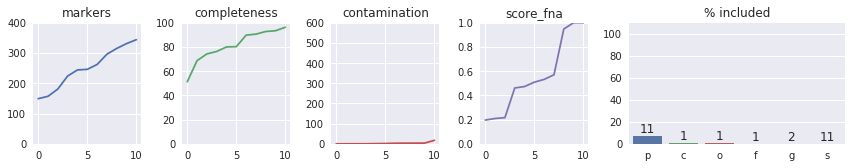

In [36]:
examine_set(singles['phylum'])

8


/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


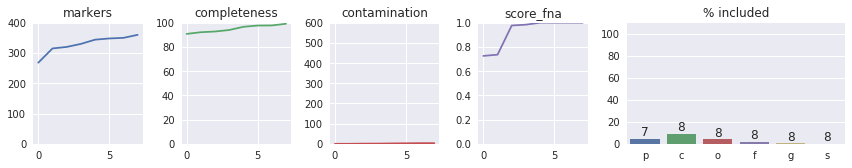

In [37]:
examine_set(singles['class'])

29


/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


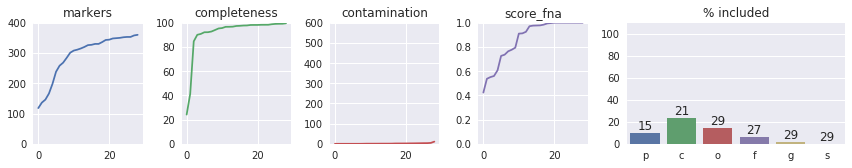

In [38]:
examine_set(singles['order'])

80


/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


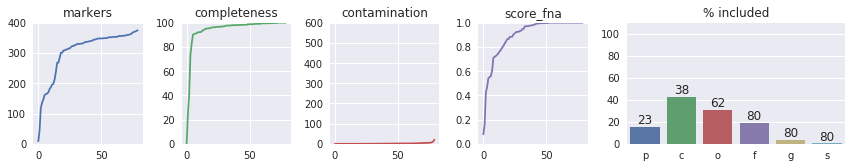

In [39]:
examine_set(singles['family'])

834


/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


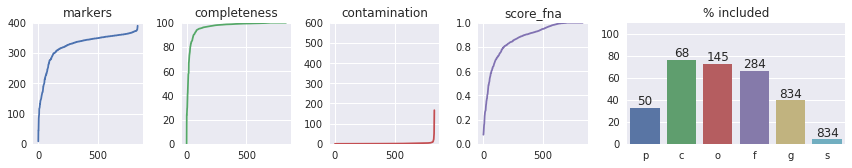

In [40]:
examine_set(singles['genus'])

18227


/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


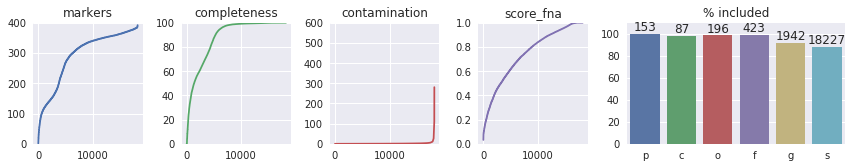

In [41]:
examine_set(singles['species'])

No defined taxonomy above species

In [42]:
df_notax = df[df['phylum'].isnull() & df['class'].isnull()
               & df['order'].isnull() & df['family'].isnull()
               & df['genus'].isnull() & df['species'].notnull()]
print('%d genomes belonging to %d species'
      % (df_notax.shape[0], df_notax['species'].nunique()))

519 genomes belonging to 504 species


519


/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


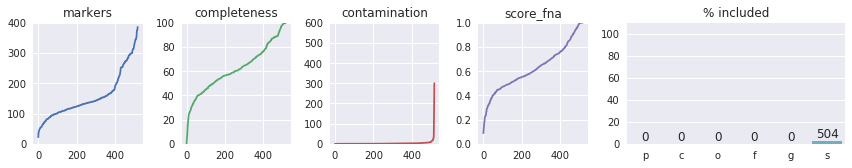

In [43]:
examine_set(df_notax.index)

495


/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


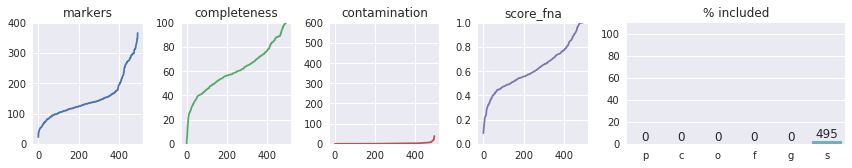

In [44]:
single_notax = df_notax.groupby('species').filter(lambda x: len(x) == 1).index
examine_set(single_notax)

Prototype selection

In [45]:
k = 11000  # number of prototypes to keep

In [46]:
%time prototypes = prototype_selection_destructive_maxdist(dm, k)
print('Sum of distances: %d.' % distance_sum(prototypes, dm))

CPU times: user 47.6 s, sys: 33.9 s, total: 1min 21s
Wall time: 1min 25s
Sum of distances: 60152796.


11000


/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


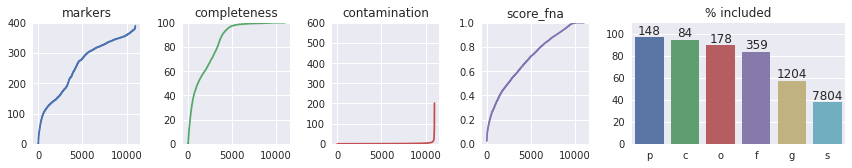

In [47]:
examine_set(prototypes)

### Formal sampling

Procedures:
 1. Exclude genomes with contamination > 10% or marker gene count < 100.
 2. Include NCBI reference and representative genomes.
 3. Include only representatives of each phylum to genus.
 4. Include only representatives of each species without defined lineage.
 5. Run prototype selection based on the MinHash distance matrix, with already included genomes as seeds, to obtain a total of 11000 genomes.
 6. For each phylum to genus, and species without defined lineage, select one with highest marker gene count.

In [48]:
chosen = set()

Step 1: Exclude genomes with contamination > 10% or marker gene count < 100

In [49]:
dfp = df.query('contamination <= 10 and markers >= 100')
print('Genomes passed quality filtering: %d' % dfp.shape[0])

Genomes passed quality filtering: 84617


84617


/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


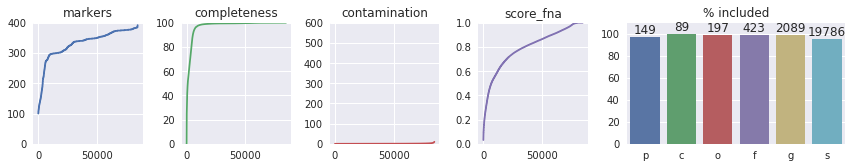

In [50]:
examine_set(dfp.index)

Step 2: Include NCBI reference and representative genomes

In [51]:
refp = dfp[dfp['refseq_category'] != 'na'].index
chosen.update(refp)
print('Added NCBI reference and representative genomes: %d' % len(refp))

Added NCBI reference and representative genomes: 5082


5082


/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


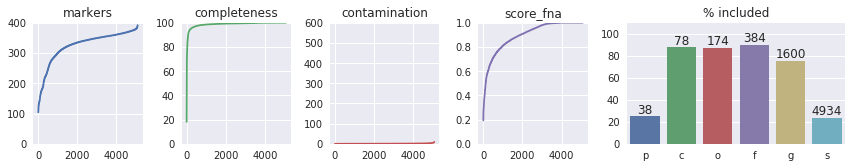

In [52]:
examine_set(chosen)

Step 3: Include only representatives of each phylum to genus

In [53]:
reports = []
for rank in ('phylum', 'class', 'order', 'family', 'genus'):
    single_taxa = dfp.groupby(rank).filter(lambda x: len(x) == 1).index
    toadd = set(single_taxa) - chosen
    chosen.update(toadd)
    reports.append('%s: %s' % (rank, len(toadd)))
print('Added taxonomic groups: %s' % ', '.join(reports))

Added taxonomic groups: phylum: 14, class: 4, order: 12, family: 14, genus: 333


5459


/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


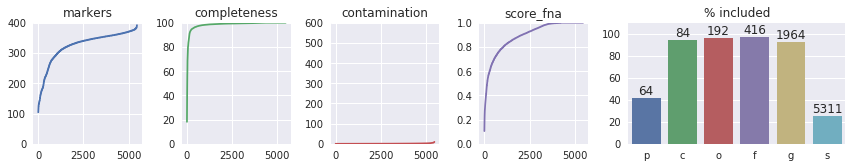

In [54]:
examine_set(chosen)

Step 4: Include only representatives of each species without defined lineage

In [55]:
dfp_notax = dfp[dfp['phylum'].isnull() & dfp['class'].isnull()
                & dfp['order'].isnull() & dfp['family'].isnull()
                & dfp['genus'].isnull() & dfp['species'].notnull()]
single_notax = dfp_notax.groupby('species').filter(lambda x: len(x) == 1).index
toadd = set(single_notax) - chosen
chosen.update(toadd)
print('Added species without lineage: %d' % len(toadd))

Added species without lineage: 380


5839


/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


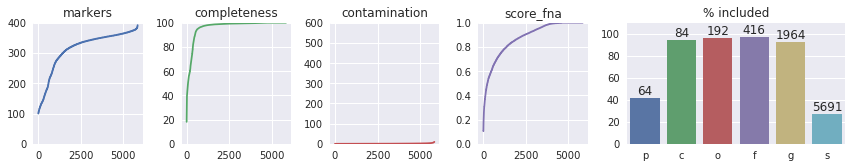

In [56]:
examine_set(chosen)

Step 5: Run prototype selection based on the MinHash distance matrix, with already included genomes as seeds, to obtain a total of 11000 genomes

In [57]:
%time dmp = dm.filter(dfp.index).copy()
len(dmp.ids)

CPU times: user 43min 58s, sys: 11min 19s, total: 55min 18s
Wall time: 59min 11s


84617

In [58]:
%time prototypes = prototype_selection_destructive_maxdist(dmp, 11000, chosen)
print('Sum of distances: %d.' % distance_sum(prototypes, dmp))

CPU times: user 42.7 s, sys: 36.9 s, total: 1min 19s
Wall time: 1min 28s
Sum of distances: 59433077.


In [59]:
toadd = set(prototypes) - chosen
chosen.update(toadd)
print('Added prototypes: %d' % len(toadd))

Added prototypes: 5161


11000


/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


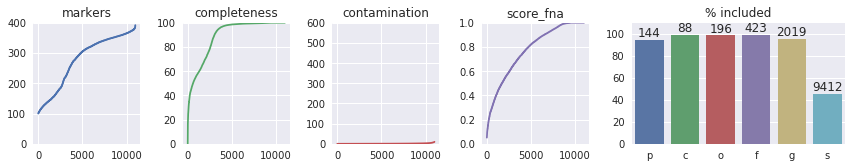

In [60]:
examine_set(chosen)

Step 6: For each phylum to genus, and species without defined lineage, select one with highest marker gene count

In [61]:
reports = []
dfc = dfp[dfp.index.isin(chosen)]
for rank in ('phylum', 'class', 'order', 'family', 'genus'):
    toadd = set()
    chosen_taxa = dfc[rank].dropna().unique()
    for taxon in dfp[rank].dropna().unique():
        if not taxon in chosen_taxa:
            toadd.add(dfp[dfp[rank] == taxon]['markers'].idxmax())
    chosen.update(toadd)
    reports.append('%s: %d' % (rank, len(toadd)))
    dfc = dfp[dfp.index.isin(chosen)]
print('Added taxonomic groups: %s' % ', '.join(reports))

Added taxonomic groups: phylum: 5, class: 1, order: 1, family: 0, genus: 70


In [62]:
toadd = set()
dfc_notax = dfc[dfc.index.isin(dfp_notax.index)]
for species in dfp_notax[~dfp_notax.index.isin(single_notax)]['species'].unique():
    if dfc_notax.query('species == "%s"' % species).shape[0] == 0:
        toadd.add(dfp_notax.query('species == "%s"' % species)['markers'].idxmax())
chosen.update(toadd)
dfc = dfp[dfp.index.isin(chosen)]
print('Added species without lineage: %d' % len(toadd))

Added species without lineage: 2


11079


/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


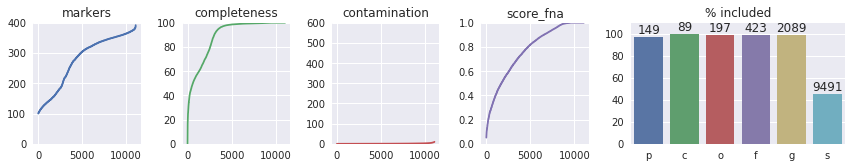

In [63]:
examine_set(chosen)

In [64]:
dfc['markers'].describe()

count    11079.000000
mean       278.761441
std         85.486634
min        100.000000
25%        199.000000
50%        315.000000
75%        349.000000
max        392.000000
Name: markers, dtype: float64

/home/qiz173/Programs/Miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


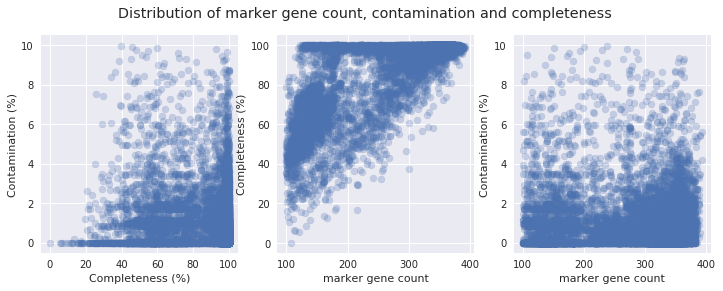

In [65]:
mpl.rcParams['figure.figsize'] = (12, 4)
f, axarr = plt.subplots(1, 3)
axarr[0].scatter(x='completeness', y='contamination', alpha=0.25, data=dfc)
axarr[0].set_xlabel('Completeness (%)')
axarr[0].set_ylabel('Contamination (%)');
axarr[1].scatter(x='markers', y='completeness', alpha=0.25, data=dfc)
axarr[1].set_xlabel('marker gene count')
axarr[1].set_ylabel('Completeness (%)');
axarr[2].scatter(x='markers', y='contamination', alpha=0.25, data=dfc)
axarr[2].set_xlabel('marker gene count')
axarr[2].set_ylabel('Contamination (%)')
plt.suptitle('Distribution of marker gene count, contamination and completeness');

Export results

In [66]:
with open('sampled.txt', 'w') as f:
    for g in sorted(chosen):
        f.write('%s\n' % g)

In [67]:
df['chosen'] = df.index.isin(chosen)

In [68]:
df.to_csv('summary_sampled.tsv', sep='\t')